In [2]:
import mode_weights_torus
import mode_weights
import numpy as np
import matplotlib.pyplot as plt

## Torus tests

In [5]:
# Target preparation:

n_center = 2
dim = 1
sigma_min, sigma_max = 0.08, 0.08
centers = np.array([np.array([0.25]), np.array([0.75])]) #np.random.uniform(-5, 5, (n_center, dim))
sigma_star = np.random.uniform(sigma_min, sigma_max , (n_center))
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * mode_weights_torus.compute_gaussian_density(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return mode_weights_torus.compute_gaussian_density(X - centers[0], sigma_star[0])

def nu_2(X):
    return mode_weights_torus.compute_gaussian_density(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.array([1/3, 2/3]) # equal
n_tot = 800
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    raw_samples = np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i]
    X_samples.append(np.mod(raw_samples, np.ones((n_samples[i],dim)) ))
    U_samples.append(U(X_samples[-1]))


In [6]:
# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 1
bw = ['silverman']*n_center

solver = mode_weights_torus.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
#print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
#print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_quad)))


Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.34s.
Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Gradient descent done ; In 46 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.75685011 0.24314989]


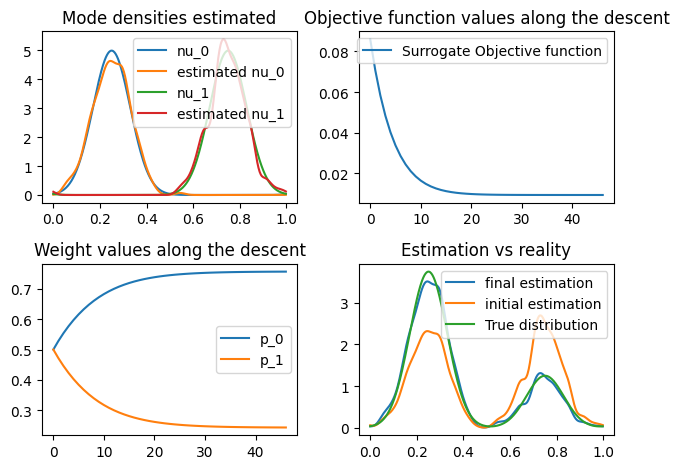

In [7]:
#########################################################################################################################

# Graph display

alpha = solver.alpha

fig,ax = plt.subplots(2,2)

X_eval = (np.arange(400)/400).reshape(-1, 1)
estimated_modes = []
real_modes = []
for i in range(n_center):
    real_modes.append(nu[i](X_eval))
    estimated_modes.append(mode_weights_torus.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
    ax[0][0].plot(X_eval, real_modes[-1], label='nu_'+str(i))
    ax[0][0].plot(X_eval, estimated_modes[-1], label='estimated nu_'+str(i))

ax[0][0].set_title('Mode densities estimated')
ax[0][0].legend()

y_1 = []
for i in range(len(solver.p_list)):
    val = solver.surrogate_function(solver.p_list[i])
    y_1.append(val)
ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='Surrogate Objective function')
ax[0][1].set_title('Objective function values along the descent')
ax[0][1].legend()

#y_2=[]
#for i in range( M ):
#    y_2.append(KL_wrt_mu(solver, U, solver.p_list[i%len(solver.p_list)], solver.sigma_list[i%len(solver.sigma_list)]))
#ax[2][1].plot(np.arange(M), y_2, label='Ideal objective function')
#ax[2][1].set_title('Objective function values along the descent')
#ax[2][1].legend()

for i in range(n_center):
    ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
ax[1][0].set_title('Weight values along the descent')
ax[1][0].legend()

y = solver.evaluate(X_eval, solver.p_list[-1])
z = solver.evaluate(X_eval, solver.p_list[0])
ax[1][1].plot(X_eval, y, label='final estimation')
ax[1][1].plot(X_eval, z, label='initial estimation')
ax[1][1].plot(X_eval, np.exp(-U(X_eval)), label='True distribution')
ax[1][1].set_title('Estimation vs reality')
ax[1][1].legend()

plt.tight_layout()
plt.show()

## Tests in high dimension on the whole space

In [ ]:
# Target preparation:

def place_1D_points_on_first_axis(points, d):
    return np.concatenate([points.reshape(-1,1), np.zeros((len(points), d-1))], axis=1)

dim = 2
n_center = 2
centers_loc_first_axis = np.array([np.array([-1]), np.array([1])])
centers = place_1D_points_on_first_axis(centers_loc_first_axis, dim)
sigma_star = 0.3, 0.3
c_star = np.array([0.75, 0.25])#np.random.uniform(0,1, (n_center))
p_star = c_star/np.sum(c_star)

def g(X, sigma): # X: (n,d) -> we want as an output smth of size (n) with ith component g(x[i]) 
    d = len(X[0])
    return np.exp(-np.linalg.norm(X, axis=1)**2/(2*sigma**2))/(sigma**d * (2*np.pi)**(d/2))

def U(X):# X: (n,d)
    density_value = np.zeros((len(X)))
    for i in range(n_center):
        density_value += p_star[i] * g(X - centers[i], sigma_star[i])
    return -np.log(density_value)

def nu_1(X):
    return g(X - centers[0], sigma_star[0])

def nu_2(X):
    return g(X - centers[1], sigma_star[1])

nu = [nu_1, nu_2]

sample_repartition = np.ones((n_center))/n_center # equal
n_tot = 2400
arr = sample_repartition * n_tot
out = np.empty_like(arr, dtype=np.int64)
n_samples = np.ceil(arr, out, casting='unsafe')
n_tot = np.sum(n_samples) # corrected due to thresholding
X_samples, U_samples = [], []
for i in range(n_center):
    X_samples.append( np.random.normal(0, sigma_star[i], (n_samples[i],dim)) + centers[i] )
    U_samples.append(U(X_samples[-1]))
    

In [22]:
# Algorithm parametrisation:

p0 = np.ones((n_center))/n_center
h = 0.1
max_iter = 400
eps = 0.0001
KL_type = 1
bw = ['silverman']*n_center

solver = mode_weights.GD_estimator(KL_type, p0, U_samples, X_samples, h, eps, max_iter, bw)

solver.optimise()

#print('Bandwidth selection: ' + str(solver.alpha))
print('Ideal weights: ' + str(p_star))
print('Estimated weights: ' + str(solver.p_list[-1]))
#print('Modes standard deviation: ' + str(sigma_star))
#print('Surrogate evaluation at the beginning of the GD: ' + str(solver.surrogate_function(solver.p_list[0])))
#print('Surrogate evaluation at the end of the GD: ' + str(solver.surrogate_function()))
#X_quad = 6 * ((np.arange(400)/400).reshape(-1, 1)*2-1)
#print('Real target evaluation at the end of the GD: ' + str(solver.objective_function(U, nu, X_quad)))

Starting bandwidth computations and KDE evaluations in the training points...
Done. Took 0.25s.
Iteration 0
Iteration 20
Iteration 40
Gradient descent done ; In 47 iterations, the minimum displacement has been reached.
Took 0.01s.
Ideal weights: [0.75 0.25]
Estimated weights: [0.75018213 0.24981787]


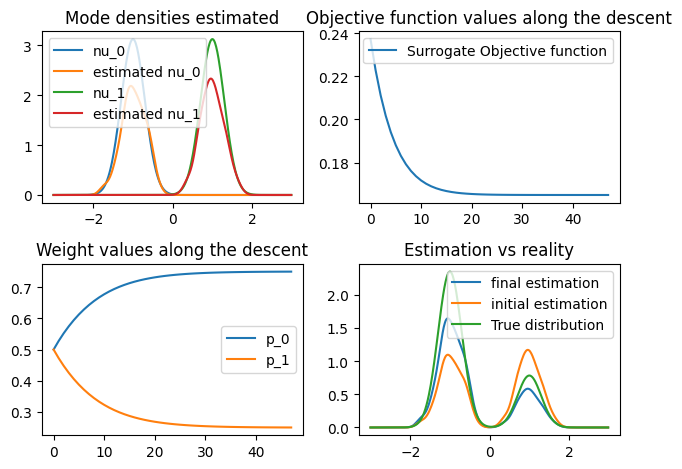

In [23]:

alpha = solver.alpha

fig,ax = plt.subplots(2,2)

X_eval = place_1D_points_on_first_axis((6 * ((np.arange(400)/400)-0.5)).reshape(-1,1), dim)
estimated_modes = []
real_modes = []
for i in range(n_center):
    real_modes.append(g(X_eval - centers[i], sigma_star[i]))
    estimated_modes.append(mode_weights.KDE_evaluation(X_samples[i], X_eval, alpha[i]))
    ax[0][0].plot(X_eval[:,0], real_modes[-1], label='nu_'+str(i))
    ax[0][0].plot(X_eval[:,0], estimated_modes[-1], label='estimated nu_'+str(i))

ax[0][0].set_title('Mode densities estimated')
ax[0][0].legend()

y_1 = []
for i in range(len(solver.p_list)):
    val = solver.surrogate_function(solver.p_list[i])
    y_1.append(val)
ax[0][1].plot(np.arange(len(solver.p_list)), y_1, label='Surrogate Objective function')
ax[0][1].set_title('Objective function values along the descent')
ax[0][1].legend()

#y_2=[]
#for i in range( M ):
#    y_2.append(KL_wrt_mu(solver, U, solver.p_list[i%len(solver.p_list)], solver.sigma_list[i%len(solver.sigma_list)]))
#ax[2][1].plot(np.arange(M), y_2, label='Ideal objective function')
#ax[2][1].set_title('Objective function values along the descent')
#ax[2][1].legend()

for i in range(n_center):
    ax[1][0].plot(np.arange(len(solver.p_list)), np.array(solver.p_list)[:,i], label='p_'+str(i))
ax[1][0].set_title('Weight values along the descent')
ax[1][0].legend()

y = solver.evaluate(X_eval, solver.p_list[-1])
z = solver.evaluate(X_eval, solver.p_list[0])
ax[1][1].plot(X_eval[:,0], y, label='final estimation')
ax[1][1].plot(X_eval[:,0], z, label='initial estimation')
ax[1][1].plot(X_eval[:,0], np.exp(-U(X_eval)), label='True distribution')
ax[1][1].set_title('Estimation vs reality')
ax[1][1].legend()

plt.tight_layout()
plt.show()